# MNIST Handwriting Recognition with TensorFlow
https://www.youtube.com/watch?v=72s6hJwyfDg

## TensorFlow vs Keras
- **TensorFlow**: Low-level library (like NumPy for deep learning). Rich ecosystem, fine-grained control.
- **Keras**: High-level API built ON TOP of TensorFlow. Easy-to-use abstraction layer.

Think of it like: TensorFlow = engine, Keras = steering wheel.

In [2]:
# ============================================
# IMPORTS
# ============================================
# TensorFlow: Google's open-source deep learning framework
# We access Keras through tf.keras (Keras is now part of TensorFlow)
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.2


In [3]:
# ============================================
# LOAD DATASET
# ============================================
# MNIST: Famous dataset of handwritten digits (0-9)
# - 70,000 grayscale images, each 28x28 pixels
# - The "Hello World" of machine learning

mnist = tf.keras.datasets.mnist

# load_data() splits into:
# - Training set (60,000): What the model learns from
# - Test set (10,000): What we evaluate on (model NEVER sees during training)
# X = images (features/inputs)
# y = labels (targets/answers)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# NORMALIZE: Scale pixel values from 0-255 to 0-1
# WHY? Neural networks work better with small numbers:
# - Prevents exploding gradients
# - Faster convergence
# - More stable training
X_train, X_test = X_train / 255.0, X_test / 255.0

In [4]:
# Check data shapes
print(f"X_train shape: {X_train.shape}")  # (60000, 28, 28) = 60k images, 28x28 pixels
print(f"y_train shape: {y_train.shape}")  # (60000,) = 60k labels (integers 0-9)
print(f"X_test shape: {X_test.shape}")    # (10000, 28, 28)
print(f"y_test shape: {y_test.shape}")    # (10000,)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


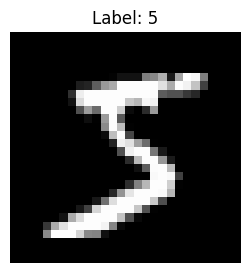

In [5]:
# Visualize a sample image
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [6]:
# ============================================
# BUILD MODEL / ARCHITECTURE
# ============================================
# Sequential: layers stack one after another (input → layer1 → layer2 → output)
# This is the simplest way to build a neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

model = Sequential()

# INPUT LAYER: Define the shape of incoming data
# (28, 28) = each image is 28x28 pixels
model.add(Input((28, 28)))

# FLATTEN LAYER: Reshape 2D image into 1D array
# (28, 28) → (784,) because Dense layers need 1D input
# No learnable parameters, just reshapes data
model.add(Flatten())

# DENSE (FULLY CONNECTED) LAYER: The "learning" layer
# - 128 neurons: each connected to ALL 784 inputs
# - Each connection has a weight (learnable parameter)
# - activation='relu': ReLU (Rectified Linear Unit)
#   ReLU(x) = max(0, x) → outputs x if positive, else 0
#   WHY ReLU? Adds non-linearity so network can learn complex patterns
#   Without activation, stacking layers = just one big linear function
model.add(Dense(128, activation='relu'))

# DROPOUT LAYER: Regularization technique
# - Randomly "turns off" 20% of neurons during TRAINING
# - Forces network to not rely on specific neurons
# - Prevents overfitting (memorizing vs generalizing)
# - Disabled during prediction (all neurons active)
model.add(Dropout(0.2))

# OUTPUT LAYER: 10 neurons (one per digit 0-9)
# NO SOFTMAX HERE - outputs raw scores called "logits"
# WHY? More numerically stable when combined with from_logits=True in loss
# The loss function will apply softmax internally
model.add(Dense(10))  # Raw logits output

In [7]:
# ============================================
# TEST UNTRAINED MODEL
# ============================================
# Pass one image through to see what the untrained model outputs
# Output will be 10 "logits" (raw scores) - one per digit class

nonsense_prediction = model(X_train[:1]).numpy()

print("Raw logits (nonsense because untrained):")
print(nonsense_prediction)
print(f"\nShape: {nonsense_prediction.shape}")  # (1, 10) = 1 sample, 10 classes

Raw logits (nonsense because untrained):
[[ 0.6019714  -0.2683456  -0.33950067  0.3597406  -0.31887192  0.3886709
  -0.3568244  -0.6213937  -0.13945    -0.20903116]]

Shape: (1, 10)


In [8]:
# SOFTMAX: Convert logits to probabilities
# - Makes outputs more interpretable (0-1 range, sum to 1)
# - softmax(x_i) = e^x_i / sum(e^x_j)
# - Highest logit → highest probability

probabilities = tf.nn.softmax(nonsense_prediction).numpy()
print("After softmax (probabilities):")
print(probabilities)
print(f"\nSum: {probabilities.sum():.4f}")  # Should be 1.0
print(f"Predicted class: {probabilities.argmax()} (actual: {y_train[0]})")

After softmax (probabilities):
[[0.18524405 0.07758368 0.07225504 0.14539342 0.07376105 0.14966112
  0.07101409 0.05450591 0.08825697 0.08232472]]

Sum: 1.0000
Predicted class: 0 (actual: 5)


In [9]:
# ============================================
# LOSS FUNCTION
# ============================================
# Loss = how wrong the model is (lower = better)
# Training goal: minimize this number

from tensorflow.keras.losses import SparseCategoricalCrossentropy

# SparseCategoricalCrossentropy breakdown:
# - "Sparse": Labels are integers (5, 3, 7...) not one-hot ([0,0,0,0,0,1,0,0,0,0])
# - "Categorical": Multi-class classification (more than 2 classes)
# - "CrossEntropy": Mathematical formula comparing probability distributions
#
# from_logits=True: CRITICAL!
# - Tells loss function our model outputs RAW LOGITS, not probabilities
# - Loss function applies softmax internally
# - WHY? More numerically stable (avoids log(0) errors)

loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Expected loss for random guessing:
# - 10 classes = 1/10 = 10% chance of being right
# - Cross-entropy loss = -log(probability)
# - -log(1/10) ≈ 2.3
expected_loss = -tf.math.log(1/10)
actual_loss = loss_fn(y_train[:1], nonsense_prediction)

print(f"Expected loss (random guess): {expected_loss.numpy():.4f}")
print(f"Actual loss (untrained model): {actual_loss.numpy():.4f}")
print("(Close to expected = model is randomly guessing, as expected!)")

Expected loss (random guess): 2.3026
Actual loss (untrained model): 1.8994
(Close to expected = model is randomly guessing, as expected!)


In [10]:
# ============================================
# COMPILE MODEL
# ============================================
# Compile = configure HOW the model will learn
# Must be done before training

from tensorflow.keras.optimizers import Adam

# OPTIMIZER: Algorithm that updates weights to minimize loss
# Adam (Adaptive Moment Estimation):
# - Most popular optimizer, works well in most cases
# - Adapts learning rate for each parameter
# - Combines momentum + RMSprop benefits
#
# learning_rate: How big each weight update is
# - Too high (0.1): Overshoots, unstable, loss may explode
# - Too low (0.0001): Very slow training
# - 0.01: Aggressive but often works well
# - 0.001: Default, safer choice
optimizer = Adam(learning_rate=0.01)

# model.compile() parameters:
# - optimizer: How to update weights
# - loss: What to minimize (our cross-entropy function)
# - metrics: What to display during training (accuracy %)
model.compile(
    optimizer=optimizer,
    loss=loss_fn,  # SparseCategoricalCrossentropy(from_logits=True)
    metrics=['accuracy']
)

In [11]:
# ============================================
# TRAIN MODEL
# ============================================
# model.fit() = where the actual learning happens!
#
# What happens each EPOCH (one pass through all training data):
# 1. FORWARD PASS: Images flow through network → predictions
# 2. CALCULATE LOSS: Compare predictions to actual labels
# 3. BACKWARD PASS (Backpropagation): Calculate gradients
#    - How much did each weight contribute to the error?
# 4. UPDATE WEIGHTS: Optimizer adjusts weights to reduce loss
#
# epochs=10: Go through ALL 60,000 images 10 times
# More epochs = more learning (but risk overfitting)
#
# WATCH FOR:
# - loss should DECREASE (model getting better)
# - accuracy should INCREASE (more correct predictions)

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8078 - loss: 2.0411
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8248 - loss: 4.0101
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8271 - loss: 5.6564
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8280 - loss: 6.9391
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8296 - loss: 8.3890
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8280 - loss: 9.6539
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8295 - loss: 10.7206
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8314 - loss: 12.1751
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8302 - loss: 13.4741
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8314 - loss: 14.7291


In [12]:
# ============================================
# EVALUATE MODEL
# ============================================
# Test on data the model has NEVER seen during training
# This shows how well the model generalizes to new data
#
# Returns: [loss, accuracy]
# - If test accuracy << training accuracy → overfitting
# - If test accuracy ≈ training accuracy → good generalization

model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8556 - loss: 13.1936


[13.193587303161621, 0.8555999994277954]

In [13]:
# ============================================
# MAKE PREDICTIONS
# ============================================
# Use the trained model to predict on new data

# Get prediction for first test image
prediction_logits = model(X_test[:1])

# Convert logits → probabilities → class
predicted_class = tf.argmax(tf.nn.softmax(prediction_logits), axis=1)

print(f"Predicted: {predicted_class.numpy()[0]}")
print(f"Actual: {y_test[0]}")

Predicted: 7
Actual: 7


## Hyperparameter Tuning
Systematically test different model configurations to find the best one.

In [ ]:
# Manual Hyperparameter Comparison
# Test different configurations and compare results

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Configurations to test
# Each dict defines a different model architecture
configs = [
    {'neurons': 32,  'dropout': 0.1, 'lr': 0.001},
    {'neurons': 64,  'dropout': 0.2, 'lr': 0.001},
    {'neurons': 128, 'dropout': 0.2, 'lr': 0.001},
    {'neurons': 128, 'dropout': 0.3, 'lr': 0.01},
    {'neurons': 256, 'dropout': 0.3, 'lr': 0.001},
]

results = []

for i, config in enumerate(configs):
    print(f"\n--- Config {i+1}/{len(configs)}: {config} ---")
    
    # Build model with this config
    model = Sequential([
        Input((28, 28)),
        Flatten(),
        Dense(config['neurons'], activation='relu'),
        Dropout(config['dropout']),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=config['lr']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train (fewer epochs for speed)
    model.fit(X_train, y_train, epochs=5, verbose=0)
    
    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    
    results.append({**config, 'accuracy': acc, 'loss': loss})
    print(f"Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# Find best configuration
best = max(results, key=lambda x: x['accuracy'])
print(f"\n✓ Best config: {best}")


--- Config 1/5: {'neurons': 32, 'dropout': 0.1, 'lr': 0.001} ---
Accuracy: 0.9173, Loss: 0.3019

--- Config 2/5: {'neurons': 64, 'dropout': 0.2, 'lr': 0.001} ---


In [ ]:
# Visualize results as a table
import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values('accuracy', ascending=False)
df['accuracy'] = df['accuracy'].apply(lambda x: f"{x:.4f}")
df['loss'] = df['loss'].apply(lambda x: f"{x:.4f}")
print("Results sorted by accuracy:\n")
df

### Keras Tuner (Automated Search)
More powerful automated hyperparameter search. Install with: `pip install keras-tuner`

In [ ]:
# Install keras-tuner (run once)
# !pip install keras-tuner

import keras_tuner as kt

def build_model(hp):
    """
    Build model with tunable hyperparameters.
    hp = hyperparameter object that lets us define search ranges
    """
    model = Sequential()
    model.add(Input((28, 28)))
    model.add(Flatten())
    
    # Tune: number of neurons in first layer (choices: 32, 64, 128, 256)
    model.add(Dense(
        units=hp.Choice('neurons', values=[32, 64, 128, 256]),
        activation='relu'
    ))
    
    # Tune: dropout rate (range: 0.1 to 0.5, step 0.1)
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Tune: optional second hidden layer
    if hp.Boolean('second_layer'):
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))
    
    # Tune: learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create tuner - RandomSearch tries random combinations
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',      # What to optimize
    max_trials=10,                 # Number of different configs to try
    executions_per_trial=1,        # Train each config once
    directory='tuner_results',     # Where to save results
    project_name='mnist_tuning'
)

# Show search space
tuner.search_space_summary()

In [ ]:
# Run the hyperparameter search
# This will train 10 different model configurations
tuner.search(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1
)

In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters Found:")
print(f"  - Neurons: {best_hp.get('neurons')}")
print(f"  - Dropout: {best_hp.get('dropout')}")
print(f"  - Learning Rate: {best_hp.get('learning_rate')}")
print(f"  - Second Layer: {best_hp.get('second_layer')}")

# Show top 3 results
print("\nTop 3 trials:")
tuner.results_summary(num_trials=3)

In [ ]:
# Build the best model and train with more epochs
best_model = tuner.hypermodel.build(best_hp)

# Train the best model for longer
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping: stop training if no improvement for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True  # Keep the best weights
)

print("Training best model with more epochs...")
best_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Final evaluation
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\n✓ Final Test Accuracy: {accuracy:.4f}")